In [1]:
import pandas_datareader.data as web
# import sklearn.mixture as mix
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn import hmm



TMV AND TIME

In [2]:


arr=[]
for j in np.arange(0.01,0.02,0.01):
#     df = web.DataReader(['sp500'], 'fred', start = '2000-01-03')


#     df.reset_index(inplace = True)
    df=pd.read_excel (r'/Users/devanshjoshi/Desktop/KOTAK/Data_Nifty.xlsx')
    

    new_data=pd.read_excel(r'/Users/devanshjoshi/Desktop/new_data.xlsx')
    add=new_data[["PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]]
    df=pd.concat([df, add], axis=1)
    print(df.head())


    x=df['Close']
    x=x.to_numpy()


    high=x[0]
    low=x[0]
    returns=[]
    tmv=[]
    threshold=j
    arr_time=[]
    ## 0.056 best for ret, vol, 66 ret and 22 ret
    ## 0.05 quite stable for new_data but graph fluctuates
    ## 0.08 not stable but predictions are accurate and graph stable-ish
    time=0
    up=0
    down=0
    dc=0
    time_high=0
    time_low=0
    first_time=0
    for i in range(1,len(x)):
        time=time+1
        if(up==0 and down==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
                first_time=time
            elif(x[i]<=(1-threshold)*low):
                down=1
                up=0
                low=x[i]
                time_low=time
                first_time=time
            else:
                pass
        elif(up==1 and dc==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
                dc=1
                down=1
                up=0
                low=x[i]
                time_low=time
            else:
                pass
        elif(down==1 and dc==0):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
                dc=1
                down=0
                up=1
                high=x[i]
                time_high=time
            else:
                pass
        elif(up==1 and dc==1):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
    #             r=[(high-low)/(low*time)]*time /////WORKS

                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(low*t_bw_trend))]*t_bw_trend
                tm=[abs((high-low)/(low*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                low=x[i]
                time_low=time
                up=0
                down=1
            else:
                pass
        elif(down==1 and dc==1):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
    #             r=[abs((low-high)/(high*time))]*time ////WORKS
                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(high*t_bw_trend))]*t_bw_trend
                tm=[abs((low-high)/(high*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                high=x[i]
                time_high=time
                up=1
                down=0
            else:
                pass
        else:
            pass





    buffer_beginning=[returns[0]]*first_time
    returns.extend(buffer_beginning)
    buffer_end=[returns[len(returns)-1]]*(time-(len(returns)-1))
    returns.extend(buffer_end)

    returns=np.array(returns)

    buffer_beginning=[tmv[0]]*first_time
    tmv.extend(buffer_beginning)
    buffer_end=[tmv[len(tmv)-1]]*(time-(len(tmv)-1))
    tmv.extend(buffer_end)

    tmv=np.array(tmv)

    buffer_beginning=[arr_time[0]]*first_time
    arr_time.extend(buffer_beginning)
    buffer_end=[arr_time[len(arr_time)-1]]*(time-(len(arr_time)-1))
    arr_time.extend(buffer_end)

    arr_time=np.array(arr_time)

    for i in range(len(returns)):
        returns[i]=math.log(returns[i])
    # print(" log Returns")
    # plt.plot(dates,returns)
    df['Returns']=returns
    df['TMV']=tmv
    df['Time']=arr_time



    df['Regime']=" "
    df["D_ret"]=' '
    df["D_ret"]=df["Close"].pct_change()
    df["22_ret"]=df["Close"].pct_change(22)
    df["66_ret"]=df["Close"].pct_change(66)
    # X_train["Vol"]=X_train["D_ret"]
    df["Vol"]=df["Close"].pct_change().rolling(22).std()
    df=df.dropna()
    df.head()

#     X=df.loc[:,["PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 amaze
#     X=df.loc[:,["Returns","22_ret","66_ret","VIX"]] ##0.01 or 0.04
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D"]] ##0.03 or 0.08
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 or 0.09999
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret"]] ##0.01 or 0.09999 best
    X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]] ##0.01 or 0.09

    
    scores = list()
    models = list()
    for n_components in range(1, 5):
        for idx in range(1):
            model = hmm.GaussianHMM(n_components=n_components, random_state=idx)
            model.fit(X)
            models.append(model)
            scores.append(model.score(X))
            print("No of hidden states:",n_components)
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
    model = models[np.argmax(scores)]
    df["Regime"]=model.predict(X)

    tmv_arr=df["TMV"].to_numpy()
    maxtmv=np.max(tmv_arr)
    mintmv=np.min(tmv_arr)
    time_arr=df["Time"].to_numpy()
    maxtime=np.max(time_arr)
    mintime=np.min(time_arr)



    arr1=df[["Regime", "TMV"]].groupby("Regime").mean()
    arr2=df[["Regime", "Time"]].groupby("Regime").mean()
    x_axis=arr1["TMV"]
    x_axis=x_axis.to_numpy()
    y_axis=arr2["Time"]
    y_axis=y_axis.to_numpy()
    for i in range(0,len(x_axis)):
        x_axis[i]=x_axis[i]-mintmv/(maxtmv-mintmv)
        y_axis[i]=y_axis[i]-mintime/(maxtime-mintime)
    
    arr.append((x_axis,y_axis))
# print(arr)

# plt.scatter(x_axis,y_axis,color=['red','green','blue','black'])
# plt.show()
# print("Std Deviation")
# print(excel[["Regime", "D_ret"]].groupby("Regime").std())


        Date   Close  PCT_MEMB_ABOVE_MOV_AVG_200D    VIX
0 2000-01-03  1592.2                        37.65  24.21
1 2000-01-04  1638.7                        33.13  27.01
2 2000-01-05  1595.8                        34.75  26.41
3 2000-01-06  1617.6                        36.97  25.73
4 2000-01-07  1613.3                        43.23  21.72
No of hidden states: 1
Converged: True		Score: -20907.70830115428
No of hidden states: 2
Converged: True		Score: -11626.088726878526
No of hidden states: 3
Converged: True		Score: -8423.054964442796
No of hidden states: 4
Converged: True		Score: -6225.618603386806


Threshold is: 0.01


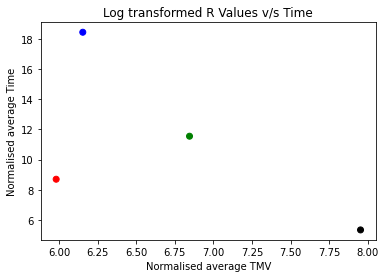

In [3]:
array=[i for i in np.arange(0.01,0.11,0.01)]
for i in range(0,len(arr)):
    print("Threshold is:",array[i])
    plt.figure()
    plt.title('Log transformed R Values v/s Time')
    plt.xlabel('Normalised average TMV')
    plt.ylabel('Normalised average Time')
    plt.scatter(arr[i][0],arr[i][1],color=['red','green','blue','black'])
plt.show()

MEAN AND STD

In [5]:
import pandas_datareader.data as web
# import sklearn.mixture as mix
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hmmlearn import hmm

arr=[]
scores = list()
models = list()
for j in np.arange(0.01,0.011,0.01):
#     df = web.DataReader('^GSPC', data_source = 'yahoo', start = '2000-01-03')


#     df.reset_index(inplace = True)
    df=pd.read_excel (r'/Users/devanshjoshi/Desktop/KOTAK/Data_Nifty.xlsx')
    dates=df['Date']

    new_data=pd.read_excel(r'/Users/devanshjoshi/Desktop/new_data.xlsx')
    add=new_data[["PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]]
    df=pd.concat([df, add], axis=1)


    x=df['Close']
    x=x.to_numpy()


    high=x[0]
    low=x[0]
    returns=[]
    tmv=[]
    threshold=j
    arr_time=[]
    ## 0.056 best for ret, vol, 66 ret and 22 ret
    ## 0.05 quite stable for new_data but graph fluctuates
    ## 0.08 not stable but predictions are accurate and graph stable-ish
    time=0
    up=0
    down=0
    dc=0
    time_high=0
    time_low=0
    first_time=0
    for i in range(1,len(x)):
        time=time+1
        if(up==0 and down==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
                first_time=time
            elif(x[i]<=(1-threshold)*low):
                down=1
                up=0
                low=x[i]
                time_low=time
                first_time=time
            else:
                pass
        elif(up==1 and dc==0):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
                dc=1
                down=1
                up=0
                low=x[i]
                time_low=time
            else:
                pass
        elif(down==1 and dc==0):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
                dc=1
                down=0
                up=1
                high=x[i]
                time_high=time
            else:
                pass
        elif(up==1 and dc==1):
            if(x[i]>=(1+threshold)*high):
                up=1
                down=0
                high=x[i]
                time_high=time
            elif(x[i]<=(1-threshold)*high):
    #             r=[(high-low)/(low*time)]*time /////WORKS

                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(low*t_bw_trend))]*t_bw_trend
                tm=[abs((high-low)/(low*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                low=x[i]
                time_low=time
                up=0
                down=1
            else:
                pass
        elif(down==1 and dc==1):
            if(x[i]<=(1-threshold)*low):
                up=0
                down=1
                low=x[i]
                time_low=time
            elif(x[i]>=(1+threshold)*low):
    #             r=[abs((low-high)/(high*time))]*time ////WORKS
                t_bw_trend=abs(time_high-time_low)
                r=[abs((low-high)/(high*t_bw_trend))]*t_bw_trend
                tm=[abs((low-high)/(high*threshold))]*t_bw_trend
    #             time=0///WORKS
                returns.extend(r)
                tmv.extend(tm)
                arr_time.extend([t_bw_trend]*t_bw_trend)
                high=x[i]
                time_high=time
                up=1
                down=0
            else:
                pass
        else:
            pass





    buffer_beginning=[returns[0]]*first_time
    returns.extend(buffer_beginning)
    buffer_end=[returns[len(returns)-1]]*(time-(len(returns)-1))
    returns.extend(buffer_end)

    returns=np.array(returns)

    buffer_beginning=[tmv[0]]*first_time
    tmv.extend(buffer_beginning)
    buffer_end=[tmv[len(tmv)-1]]*(time-(len(tmv)-1))
    tmv.extend(buffer_end)

    tmv=np.array(tmv)

    buffer_beginning=[arr_time[0]]*first_time
    arr_time.extend(buffer_beginning)
    buffer_end=[arr_time[len(arr_time)-1]]*(time-(len(arr_time)-1))
    arr_time.extend(buffer_end)

    arr_time=np.array(arr_time)

    for i in range(len(returns)):
        returns[i]=math.log(returns[i])
    # print(" log Returns")
    # plt.plot(dates,returns)
    df['Returns']=returns
    df['TMV']=tmv
    df['Time']=arr_time



    df['Regime']=" "
    df["D_ret"]=' '
    df["D_ret"]=df["Close"].pct_change()
    df["22_ret"]=df["Close"].pct_change(22)
    df["66_ret"]=df["Close"].pct_change(66)
    # X_train["Vol"]=X_train["D_ret"]
    df["Vol"]=df["Close"].pct_change().rolling(22).std()
    df=df.dropna()
    df.head()

#     X=df.loc[:,["Returns","22_ret","66_ret"]] ##0.01 amaze
#     X=df.loc[:,["Returns","22_ret","66_ret","VIX"]] ##0.01 or 0.04
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D"]] ##0.03 or 0.08
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX"]] ##0.01 or 0.09999
#     X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret"]] ##0.01 or 0.09999 best
    X=df.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]] ##0.01 or 0.09
            
    #         print(f'Converged: {model.monitor_.converged}\t\t'
    #               f'Score: {scores[-1]}')
    model = hmm.GaussianHMM(n_components=4, random_state=1)
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    
    df["Regime"]=model.predict(X)
    
    df["Regime"]=df['Regime'].shift(1)
    df["Daily"]=' '
    df["Daily"]=df["Close"].pct_change()
    MEAN=df[["Regime", "Daily"]].groupby("Regime").mean()
    STD=df[["Regime", "Daily"]].groupby("Regime").std()

#     tmv_arr=df["TMV"].to_numpy()
#     maxtmv=np.max(tmv_arr)
#     mintmv=np.min(tmv_arr)
#     time_arr=df["Time"].to_numpy()
#     maxtime=np.max(time_arr)
#     mintime=np.min(time_arr)



#     arr1=df[["Regime", "TMV"]].groupby("Regime").mean()
#     arr2=df[["Regime", "Time"]].groupby("Regime").mean()
#     x_axis=arr1["TMV"]
#     x_axis=x_axis.to_numpy()
#     y_axis=arr2["Time"]
#     y_axis=y_axis.to_numpy()
#     for i in range(0,len(x_axis)):
#         x_axis[i]=x_axis[i]-mintmv/(maxtmv-mintmv)
#         y_axis[i]=y_axis[i]-mintime/(maxtime-mintime)
    
    arr.append((MEAN,STD))
model = models[np.argmax(scores)]
# print(arr)

# plt.scatter(x_axis,y_axis,color=['red','green','blue','black'])
# plt.show()
# print("Std Deviation")
# print(excel[["Regime", "D_ret"]].groupby("Regime").std())



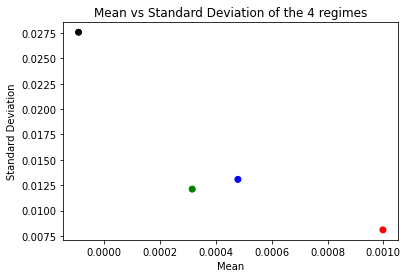

In [6]:
array=[i for i in np.arange(0.01,0.01,0.01)]
for i in range(0,len(arr)):
    
    plt.figure()
#     print("Threshold is:",array[i])
    plt.scatter(arr[i][0],arr[i][1],color=['red','green','blue','black'])
    plt.title('Mean vs Standard Deviation of the 4 regimes')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
plt.show()

In [7]:
print(arr[0][0])
print(arr[0][1])

           Daily
Regime          
0.0     0.000998
1.0     0.000315
2.0     0.000479
3.0    -0.000092
           Daily
Regime          
0.0     0.008095
1.0     0.012117
2.0     0.013074
3.0     0.027574


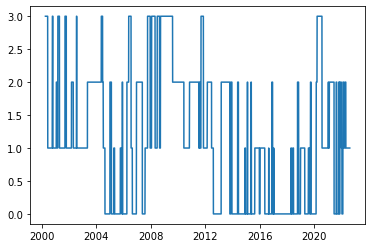

In [8]:
pred=model.predict(X)
dates=df['Date']
df_plot=pd.DataFrame()

df_plot["dates"]=dates
df_plot["pred"]=pred
df_plot.to_excel('/Users/devanshjoshi/Desktop/regimepred.xlsx')
plt.plot(dates,pred)
plt.savefig('/Users/devanshjoshi/Desktop/regimepred.eps', format='eps')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X_train,X_test=train_test_split(df,train_size=0.7,shuffle=False,random_state=26)
# arr=X_train["Returns"].to_numpy()
# arr=arr.reshape(-1,1)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
X_train=df.loc[(df['Date'] < '2003-04-06')]
X=X_train.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]] ### OLD
# X=X_train.loc[:,["Returns","66_ret","Vol"]] ### TEST
print(X.corr())
from sklearn.decomposition import PCA
pca=PCA(n_components=2)

### SCALING OR NOT
# X = StandardScaler().fit_transform(X)




                              Returns  PCT_MEMB_ABOVE_MOV_AVG_200D       VIX  \
Returns                      1.000000                     0.293315 -0.167872   
PCT_MEMB_ABOVE_MOV_AVG_200D  0.293315                     1.000000 -0.832568   
VIX                         -0.167872                    -0.832568  1.000000   
22_ret                      -0.219573                     0.094281 -0.217206   
66_ret                      -0.213916                     0.113404 -0.268093   
Vol                          0.509468                     0.232015 -0.024471   

                               22_ret    66_ret       Vol  
Returns                     -0.219573 -0.213916  0.509468  
PCT_MEMB_ABOVE_MOV_AVG_200D  0.094281  0.113404  0.232015  
VIX                         -0.217206 -0.268093 -0.024471  
22_ret                       1.000000  0.448251 -0.437758  
66_ret                       0.448251  1.000000 -0.446877  
Vol                         -0.437758 -0.446877  1.000000  


In [10]:
from scipy.stats import poisson
scores = list()
models = list()
for n_components in range(1, 5):
    for idx in range(10):
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx)
        model.fit(X)
        models.append(model)
        scores.append(model.score(X))
#         print(f'Converged: {model.monitor_.converged}\t\t'
#               f'Score: {scores[-1]}')
model = models[np.argmax(scores)]
# n=3
# model=hmm.GaussianHMM(n_components=n)
# model.fit(arr)

In [11]:
list_of_predictions=[]
mstd=[]
from datetime import datetime
from dateutil import rrule

start_date = datetime(2003, 5, 31)
end_date = datetime(2022, 6, 30)
# t=model.transmat_
# m=model.means_
# c=model.covars_

from dateutil.relativedelta import relativedelta
dt=start_date
while(dt<end_date+relativedelta(days=1)):

    
    X_train=df.loc[(df['Date'] <= dt)]
    dates=X_train["Date"]

#     X=X_train.loc[:,["PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","Returns","22_ret","66_ret","Vol"]]
    X=X_train.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]]
#     X=X_train.loc[:,["Returns","66_ret","Vol"]]  ## TEST
#     print(X_train.tail())
#     arr=X_train["Returns"].to_numpy()
#     arr=arr.reshape(-1,1)

    scores = list()
    models = list()
    for n_components in range(4,5):
        for idx in range(1):
            model = hmm.GaussianHMM(n_components=n_components,init_params="s", random_state=idx)
#             model.transmat_ = t
#             model.means_ = m
#             model.covars_ = np.array([np.diag(i) for i in c])
            model.fit(X)
            models.append(model)
            scores.append(model.score(X))
    model = models[np.argmax(scores)]
#     t=model.transmat_
#     m=model.means_
#     c=model.covars_
    pred=model.predict(X)
#     print(len(pred))
    
    
#     val=X_train["Returns"].to_numpy()
#     val=val.reshape(-1,1)
    X_train["Regime"]=pred
    X_train["Regime"]=X_train['Regime'].shift(1)
    X_train["D_ret"]=' '
    X_train["D_ret"]=X_train["Close"].pct_change()
    MEAN=X_train[["Regime", "D_ret"]].groupby("Regime").mean()
    STD=X_train[["Regime", "D_ret"]].groupby("Regime").std()

    list_of_predictions.append((dates,pred))
    mstd.append((MEAN,STD))
    dt=dt+relativedelta(months=1)

    




/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/2224172389.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Regime"]=pred
/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/2224172389.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Regime"]=X_train['Regime'].shift(1)
/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/2224172389.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [12]:
excel=pd.DataFrame()
col=0
for i in range(0,len(list_of_predictions)):
    df_add=pd.DataFrame()
    df_mstd=pd.DataFrame()
    df_rank=pd.DataFrame()
#     print(len(list_of_predictions[i][0]),len(list_of_predictions[i][1]))
    df_add[str(col)]=list_of_predictions[i][0]
#     print("1")
    col=col+1
    df_add["Pred"]=list_of_predictions[i][1]


#     print("2")
    col=col+1
#     excel = pd.concat([excel, df_add], axis=1)
    df_mstd["Mean"]=mstd[i][0]["D_ret"].to_numpy()
    df_mstd["STD"]=mstd[i][1]["D_ret"].to_numpy()
 
  ##NEW  
    df_mstd["Vals"]=df_mstd["Mean"]/df_mstd["STD"]
    nums=np.array([0,1,2,3])
    df_mstd["Regime"]=nums

    df_mstd=df_mstd.sort_values(by=["Vals"]).reset_index(drop=True)

    df_rank["Rank"]=df_mstd["Regime"]
    
    dict_map = {df_rank["Rank"][0]:'WORST' ,  df_rank["Rank"][1]:'SECOND WORST', df_rank["Rank"][2]:'SECOND BEST', df_rank["Rank"][3]:'BEST'}
    df_add["Pred"] = df_add["Pred"].map(dict_map)



  ## NEW



        
    excel = pd.concat([excel, df_add], axis=1)
    
#     excel= pd.concat([excel, df_rank], axis=1)


    


excel.to_excel("/Users/devanshjoshi/Desktop/output1.xlsx")

    
#     print(len(list_of_predictions[i]))
    

# ^^^ TYPE 1 OUTPUT

In [13]:
X_train=df.loc[(df['Date'] < '2003-04-06')]
# print(X_train.tail())
X=X_train.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]]
# arr=X_train["Returns"].to_numpy()
# arr=arr.reshape(-1,1)
from scipy.stats import poisson
scores = list()
models = list()
for n_components in range(1, 5):
    for idx in range(10):
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx)
        model.fit(X)
        models.append(model)
        scores.append(model.score(X))
#         print(f'Converged: {model.monitor_.converged}\t\t'
#               f'Score: {scores[-1]}')
model = models[np.argmax(scores)]
n=model.n_components

In [14]:
list_of_predictions=[]
returns=[]
from datetime import datetime
from dateutil import rrule
from dateutil.relativedelta import relativedelta
# t=model.transmat_
# m=model.means_
# c=model.covars_

start_date = datetime(2003, 5, 31)
end_date = datetime(2022, 6, 30)
# t=model.transmat_
# m=model.means_
# c=model.covars_


dt=start_date
while(dt<end_date+relativedelta(days=1)):
    X_train=df.loc[(df['Date'] < dt-relativedelta(months = 1))]
    X=X_train.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]]
#     arr=X_train["Returns"].to_numpy()
#     arr=arr.reshape(-1,1)
    scores = list()
    models = list()
    for n_components in range(4,5):
        for idx in range(10):
            model = hmm.GaussianHMM(n_components=n_components,init_params="s", random_state=idx)
#             model.transmat_ = t
#             model.means_ = m
#             model.covars_ = np.array([np.diag(i) for i in c])
            model.fit(X)
            models.append(model)
            scores.append(model.score(X))
    model = models[np.argmax(scores)]
#     t=model.transmat_
#     m=model.means_
#     c=model.covars_
    arr=pd.DataFrame()
    values=[]
    for i in range(model.n_components):
#         print(model.means_[i])
#         print(model.covariances_[i])
        val=model.means_[i]/np.diag(model.covars_[i])
        values.append(val[4])
    nums=np.array([0,1,2,3])
#         print(val[4])
    arr["Vals"]=values
    arr["Regime"]=nums
    arr=arr.sort_values(by=["Vals"]).reset_index(drop=True)


    
    X_test=df.loc[(df['Date'] <= dt) & (df['Date']>=dt-relativedelta(months = 1))]
    X=X_test.loc[:,["Returns","PCT_MEMB_ABOVE_MOV_AVG_200D","VIX","22_ret","66_ret","Vol"]]
    dates=X_test["Date"]


    returns.append(X_test["Close"].to_numpy())

    pred=model.predict(X)
    dict_map = {arr["Regime"][0]:'WORST' ,  arr["Regime"][1]:'SECOND WORST', arr["Regime"][2]:'SECOND BEST', arr["Regime"][3]:'BEST'}
    
    X_test['Regime']=pred
    X_test["Regime"] = X_test["Regime"].map(dict_map)
    pred=X_test["Regime"]
#     print(pred)

    list_of_predictions.append((dates,pred))
    dt=dt+relativedelta(months=1)
    

/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/1038364799.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Regime']=pred
/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/1038364799.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Regime"] = X_test["Regime"].map(dict_map)
/var/folders/lh/t7dqft5s4hz24449n4tc0ywr0000gn/T/ipykernel_48987/1038364799.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [15]:
new=[]
for i in range(0,len(returns)):
    for j in range(0,len(returns[i])):
        new.append(returns[i][j])


In [16]:
excel=pd.DataFrame(columns=['Date', 'Regime'])
col=0
for i in range(0,len(list_of_predictions)):
    df_add=pd.DataFrame()
#     print(len(list_of_predictions[i][0]),len(list_of_predictions[i][1]))
    df_add["Date"]=list_of_predictions[i][0]
#     print("1")
    col=col+1
    df_add["Regime"]=list_of_predictions[i][1]
#     print("2")
    col=col+1
    excel = pd.concat([excel, df_add], ignore_index = True)

# df_ret=pd.DataFrame()
# df_ret["Returns"]=new
# excel = pd.concat([excel,df_ret ], ignore_index = True)
# excel["Close"]=new

# print(X_baad.tail())
# print(df.tail())
excel.to_excel("/Users/devanshjoshi/Desktop/output2.xlsx")

    
#     print(len(list_of_predictions[i]))
    

# index=X_train.columns.get_loc("Regime")
# index_return=X_train.columns.get_loc("Returns")
# for i in range(0,X_train.shape[0]):
#     val=X_train.iloc[i][index_return]
#     val=val.reshape(-1,1)
#     X_train.iat[i,index]=int(hmm.predict(val))
# # print(X_train.head())


